# Result analysis

In [68]:
from dotenv import load_dotenv
import os

# Get the path to the root directory of the repository
root_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))

# Load environment variables from .env file in the root directory
load_dotenv(os.path.join(root_dir, '.env'))

True

## Import data

### Load experiment results

In [69]:
RESULTS_DIR = os.environ.get("RESULTS_PATH")
EXPERIMENT_DIR = None
print(f"The results are stored in the directory {RESULTS_DIR}")

The results are stored in the directory /home/vm-kubernetes/SRE-agent/Results


In [70]:
experiment_batches = [d for d in os.listdir(RESULTS_DIR) if os.path.isdir(os.path.join(RESULTS_DIR, d))]

for i, dir in enumerate(experiment_batches, 1):
    print(f"{i}) {dir}")

1) 20251119-plain-ReAct
2) hotel-res-full-set


In [71]:
experiment_id = input("Choose the experiment ID (the number)")

try:
    id = int(experiment_id) - 1
    if id < 0 or id >= len(experiment_batches):
        print(f"Error: Invalid experiment ID. Please choose a number between 1 and {len(experiment_batches)}")
        id = 0
        print(f"Using first experiment: {experiment_batches[id]}") 
except ValueError:
    print(f"Error: Invalid input. Please enter a number between 1 and {len(experiment_batches)}")
    id = 0
    print(f"Using first experiment: {experiment_batches[id]}")

exp_folder_name = experiment_batches[id]
EXPERIMENT_DIR = os.path.join(RESULTS_DIR,exp_folder_name)

print(f"The experiment batch selected is {EXPERIMENT_DIR}")

The experiment batch selected is /home/vm-kubernetes/SRE-agent/Results/hotel-res-full-set


In [72]:
exp_results_files = [f for f in os.listdir(EXPERIMENT_DIR) if f.endswith('.json')]
print(f"Found {len(exp_results_files)} experiments:")
for file in exp_results_files:
    print(f"  - {file}")

Found 27 experiments:
  - 2025-11-20_12-53-19_Plain-React-P2-B7---Hotel-Reservation---Container-Kill-(hotel-res-full-set).json
  - 2025-11-20_14-55-39_B---Plain-React-P3-B7---Hotel-Reservation---No-fault-(hotel-res-full-set).json
  - 2025-11-20_18-54-07_C---Plain-React-P5-B7---Hotel-Reservation---User-unregistered-MongoDB-(Geo)-(hotel-res-full-set).json
  - 2025-11-20_14-49-18_C---Plain-React-P5-B7---Hotel-Reservation---Network-loss-(hotel-res-full-set).json
  - 2025-11-20_15-20-02_B---Plain-React-P3-B7---Hotel-Reservation---Pod-failure-(hotel-res-full-set).json
  - 2025-11-20_13-14-48_Plain-React-P5-B7---Hotel-Reservation---Container-Kill-(hotel-res-full-set).json
  - 2025-11-20_18-40-32_A---Plain-React-P2-B7---Hotel-Reservation---User-unregistered-MongoDB-(Geo)-(hotel-res-full-set).json
  - 2025-11-20_14-56-29_C---Plain-React-P5-B7---Hotel-Reservation---No-fault-(hotel-res-full-set).json
  - 2025-11-20_13-30-40_Plain-React-P3-B7---Hotel-Reservation---Port-missmatch-geo-(hotel-res-ful

In [73]:
import json

experiment = exp_results_files[0]
with open(os.path.join(EXPERIMENT_DIR,experiment), 'r') as file:
    data = json.load(file)

In [74]:
def print_nested_keys(d, indent=0):
    for key in d.keys():
        print("  " * indent + str(key))
        if isinstance(d[key], dict):
            print_nested_keys(d[key], indent + 1)

print_nested_keys(data)


app_name
app_summary
target_namespace
trace_service_starting_point
problematic_pods
  problematic_pods
  info
slow_traces
  service
  traces
  info
problematic_metrics
  problematic_metrics
  info
problematic_traces
  service
  traces
  traces_count
symptoms
rca_tasks
rca_analyses_list
tasks_to_be_executed
final_report
  root_cause
  affected_resources
  evidence_summary
  investigation_summary
  detection
  localization
experiment_name
agent_configuration_name
stats
  run_id
  experiment_name
  status
  execution_time_seconds
  total_tokens
  total_cost
  langsmith_url
  agent_stats
    supervisor_agent
      total_tokens
      input_tokens
      output_tokens
      cost
      runs_count
    rca_agent
      total_tokens
      input_tokens
      output_tokens
      cost
      runs_count
    schedule_rca_tasks
      total_tokens
      input_tokens
      output_tokens
      cost
      runs_count
    planner_agent
      total_tokens
      input_tokens
      output_tokens
      cost
      

In [75]:
import pandas as pd
import json

experiments_df = pd.DataFrame()

for experiment in exp_results_files:
    try:
        with open(os.path.join(EXPERIMENT_DIR, experiment), 'r') as file:
            data = json.load(file)

            localization = data.get("final_report", {}).get("localization", [])
            if isinstance(localization, list):
                localization_str = ", ".join(localization)
            else:
                localization_str = None
    
        record = {
            "experiment_file": experiment,
            "scenario": data.get("app_name", "N/A"),
            "fault_name": data.get("testbed", {}).get("fault_name", "N/A"),
            "target_namespace": data.get("target_namespace", "N/A"),
            "trace_service_starting_point": data.get("trace_service_starting_point", "N/A"),
            "rca_tasks_per_iteration": data.get("testbed", {}).get("rca_tasks_per_iteration", 0),
            "max_tool_calls": data.get("testbed", {}).get("max_tool_calls", 0),
            "execution_time_seconds": data.get("stats", {}).get("execution_time_seconds", 0),
            "total_tokens": data.get("stats", {}).get("total_tokens", 0),
            "tokens_triage": data.get("stats", {}).get("agent_stats", {}).get("triage_agent", {}).get("total_tokens", 0),
            "tokens_planner": data.get("stats", {}).get("agent_stats", {}).get("planner_agent", {}).get("total_tokens", 0),
            "tokens_rca_worker": data.get("stats", {}).get("agent_stats", {}).get("rca_agent", {}).get("total_tokens", 0),
            "runs_count_rca": data.get("stats", {}).get("agent_stats", {}).get("rca_agent", {}).get("runs_count", 0),
            "tokens_supervisor": data.get("stats", {}).get("agent_stats", {}).get("supervisor_agent", {}).get("total_tokens", 0),
            "runs_count_supervisor": data.get("stats", {}).get("agent_stats", {}).get("supervisor_agent", {}).get("runs_count", 0),
            "detection": data.get("final_report", {}).get("detection", "N/A"),
            "localization": localization_str,
            "root_cause": data.get("final_report", {}).get("root_cause", "N/A"),
        }
        
        # Append record to dataframe
        experiments_df = pd.concat([experiments_df, pd.DataFrame([record])], ignore_index=True)
    
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Warning: Error processing {experiment}: {str(e)}")
        continue

In [76]:
experiments_df

,experiment_file,scenario,fault_name,target_namespace,trace_service_starting_point,rca_tasks_per_iteration,max_tool_calls,execution_time_seconds,total_tokens,tokens_triage,tokens_planner,tokens_rca_worker,runs_count_rca,tokens_supervisor,runs_count_supervisor,detection,localization,root_cause
0,2025-11-20_12-53-19_Plain-React-P2-B7---Hotel-...,Hotel Reservation,Container Kill,test-hotel-reservation,frontend,2,7,356.189142,69629,3674,4593,56207,2,5155,1,True,frontend,The frontend is misconfigured: it does not hav...
1,2025-11-20_14-55-39_B---Plain-React-P3-B7---Ho...,Hotel Reservation,No fault,test-hotel-reservation,frontend,3,7,6.000688,703,703,0,0,0,0,1,False,None,No analysis data available
2,2025-11-20_18-54-07_C---Plain-React-P5-B7---Ho...,Hotel Reservation,User unregistered MongoDB (Geo),test-hotel-reservation,frontend,5,7,346.199152,87880,1346,3580,76475,3,6479,1,True,geo-99d8c58c-q4m8s (container: hotel-reserv-geo),The geo service (hotel-reserv-geo) crashed on ...
3,2025-11-20_14-49-18_C---Plain-React-P5-B7---Ho...,Hotel Reservation,Network loss,test-hotel-reservation,frontend,5,7,991.011532,102371,1368,4166,88441,5,8396,1,True,frontend-69d95967fb-vxf4p,A blocking operation (sleep/event-loop/thread ...
4,2025-11-20_15-20-02_B---Plain-React-P3-B7---Ho...,Hotel Reservation,Pod failure,test-hotel-reservation,frontend,3,7,391.669170,75271,1250,4040,63729,3,6252,1,True,user-8477d787d8-2nhtl,A pod-level command/entrypoint misconfiguratio...
5,2025-11-20_13-14-48_Plain-React-P5-B7---Hotel-...,Hotel Reservation,Container Kill,test-hotel-reservation,frontend,5,7,849.525262,141049,3369,4564,124048,5,9068,1,True,frontend,Misconfiguration in the frontend: the frontend...
6,2025-11-20_18-40-32_A---Plain-React-P2-B7---Ho...,Hotel Reservation,User unregistered MongoDB (Geo),test-hotel-reservation,frontend,2,7,198.778869,39367,1144,3502,29487,2,5234,1,True,geo-99d8c58c-q4m8s,The hotel-reserv-geo process in pod geo-99d8c5...
7,2025-11-20_14-56-29_C---Plain-React-P5-B7---Ho...,Hotel Reservation,No fault,test-hotel-reservation,frontend,5,7,7.403968,703,703,0,0,0,0,1,False,None,No analysis data available
8,2025-11-20_13-30-40_Plain-React-P3-B7---Hotel-...,Hotel Reservation,Port missmatch geo,test-hotel-reservation,frontend,3,7,306.377005,58557,1209,3723,47643,3,5982,1,True,geo-6b4b89b5f5-666sz,The geo service (hotel-reserv-geo) crashed bec...
9,2025-11-20_14-17-48_Plain-React-P5-B7---Hotel-...,Hotel Reservation,Network delay,test-hotel-reservation,frontend,5,7,862.630168,157919,1119,4057,144480,4,8263,1,True,user-8477d787d8-nn6t8,Application-level configuration error in the u...


### Load fault types

In [77]:
FAULTS_CONF_DIR = os.environ.get("FAULTS_CONF_DIR")

faults_conf_files = [f for f in os.listdir(FAULTS_CONF_DIR) if f.endswith('.json')]

print(f"Found {len(faults_conf_files)} fault configuration files:")

for f in faults_conf_files:
    print(f"- {f}")


Found 9 fault configuration files:
- user_unregistered_mongodb_hotel_res.json
- noop_hotel_res.json
- network_delay_hotel_res.json
- revoke_auth_mongoDB_hotel_res.json
- pod_failure_hotel_res.json
- container_kill_hotel_res.json
- misconfig_app_hotel_res.json
- network_loss_hotel_res.json
- pod_kill_hotel_res.json


In [104]:
fault_target_dict = {}

for f in faults_conf_files:
    with open(os.path.join(FAULTS_CONF_DIR,f), 'r') as file:
        data = json.load(file)
        formatted_key = f"{data["app_name"]} - {data["fault_type"]}"
        fault_target_dict[formatted_key] = data.get("target", None)

fault_target_dict

{'Hotel Reservation - User unregistered MongoDB (Geo)': 'geo',
 'Hotel Reservation - No fault': None,
 'Hotel Reservation - Network delay': 'user',
 'Hotel Reservation - Revoke auth MongoDB (Geo)': 'geo',
 'Hotel Reservation - Pod failure': 'user',
 'Hotel Reservation - Container Kill': 'frontend',
 'Hotel Reservation - Port missmatch geo': 'geo',
 'Hotel Reservation - Network loss': 'user',
 'Hotel Reservation - Pod kill': 'recommendation'}

## Evaluation

In [105]:
type(fault_target_dict["Hotel Reservation - No fault"])

NoneType

In [106]:
def evaluate_localization(row):
    formatted_key = f"{row['scenario']} - {row['fault_name']}"
    target = fault_target_dict.get(formatted_key, None)
    localization = row['localization']

    # If no target is defined (no fault scenario), return True if localization is also None/empty
    if target is None:
        return localization is None or localization == '' or pd.isna(localization)

    # If localization is None or not a string, cannot match
    if not isinstance(localization, str):
        return False

    # Check if the target is contained in the localization string
    return target in localization


In [107]:
experiments_df['correct_localization'] = experiments_df.apply(evaluate_localization, axis=1)
experiments_df

,experiment_file,scenario,fault_name,target_namespace,trace_service_starting_point,rca_tasks_per_iteration,max_tool_calls,execution_time_seconds,total_tokens,tokens_triage,tokens_planner,tokens_rca_worker,runs_count_rca,tokens_supervisor,runs_count_supervisor,detection,localization,root_cause,correct_localization
0,2025-11-20_12-53-19_Plain-React-P2-B7---Hotel-...,Hotel Reservation,Container Kill,test-hotel-reservation,frontend,2,7,356.189142,69629,3674,4593,56207,2,5155,1,True,frontend,The frontend is misconfigured: it does not hav...,True
1,2025-11-20_14-55-39_B---Plain-React-P3-B7---Ho...,Hotel Reservation,No fault,test-hotel-reservation,frontend,3,7,6.000688,703,703,0,0,0,0,1,False,None,No analysis data available,True
2,2025-11-20_18-54-07_C---Plain-React-P5-B7---Ho...,Hotel Reservation,User unregistered MongoDB (Geo),test-hotel-reservation,frontend,5,7,346.199152,87880,1346,3580,76475,3,6479,1,True,geo-99d8c58c-q4m8s (container: hotel-reserv-geo),The geo service (hotel-reserv-geo) crashed on ...,True
3,2025-11-20_14-49-18_C---Plain-React-P5-B7---Ho...,Hotel Reservation,Network loss,test-hotel-reservation,frontend,5,7,991.011532,102371,1368,4166,88441,5,8396,1,True,frontend-69d95967fb-vxf4p,A blocking operation (sleep/event-loop/thread ...,False
4,2025-11-20_15-20-02_B---Plain-React-P3-B7---Ho...,Hotel Reservation,Pod failure,test-hotel-reservation,frontend,3,7,391.669170,75271,1250,4040,63729,3,6252,1,True,user-8477d787d8-2nhtl,A pod-level command/entrypoint misconfiguratio...,True
5,2025-11-20_13-14-48_Plain-React-P5-B7---Hotel-...,Hotel Reservation,Container Kill,test-hotel-reservation,frontend,5,7,849.525262,141049,3369,4564,124048,5,9068,1,True,frontend,Misconfiguration in the frontend: the frontend...,True
6,2025-11-20_18-40-32_A---Plain-React-P2-B7---Ho...,Hotel Reservation,User unregistered MongoDB (Geo),test-hotel-reservation,frontend,2,7,198.778869,39367,1144,3502,29487,2,5234,1,True,geo-99d8c58c-q4m8s,The hotel-reserv-geo process in pod geo-99d8c5...,True
7,2025-11-20_14-56-29_C---Plain-React-P5-B7---Ho...,Hotel Reservation,No fault,test-hotel-reservation,frontend,5,7,7.403968,703,703,0,0,0,0,1,False,None,No analysis data available,True
8,2025-11-20_13-30-40_Plain-React-P3-B7---Hotel-...,Hotel Reservation,Port missmatch geo,test-hotel-reservation,frontend,3,7,306.377005,58557,1209,3723,47643,3,5982,1,True,geo-6b4b89b5f5-666sz,The geo service (hotel-reserv-geo) crashed bec...,True
9,2025-11-20_14-17-48_Plain-React-P5-B7---Hotel-...,Hotel Reservation,Network delay,test-hotel-reservation,frontend,5,7,862.630168,157919,1119,4057,144480,4,8263,1,True,user-8477d787d8-nn6t8,Application-level configuration error in the u...,True


## Data exploration

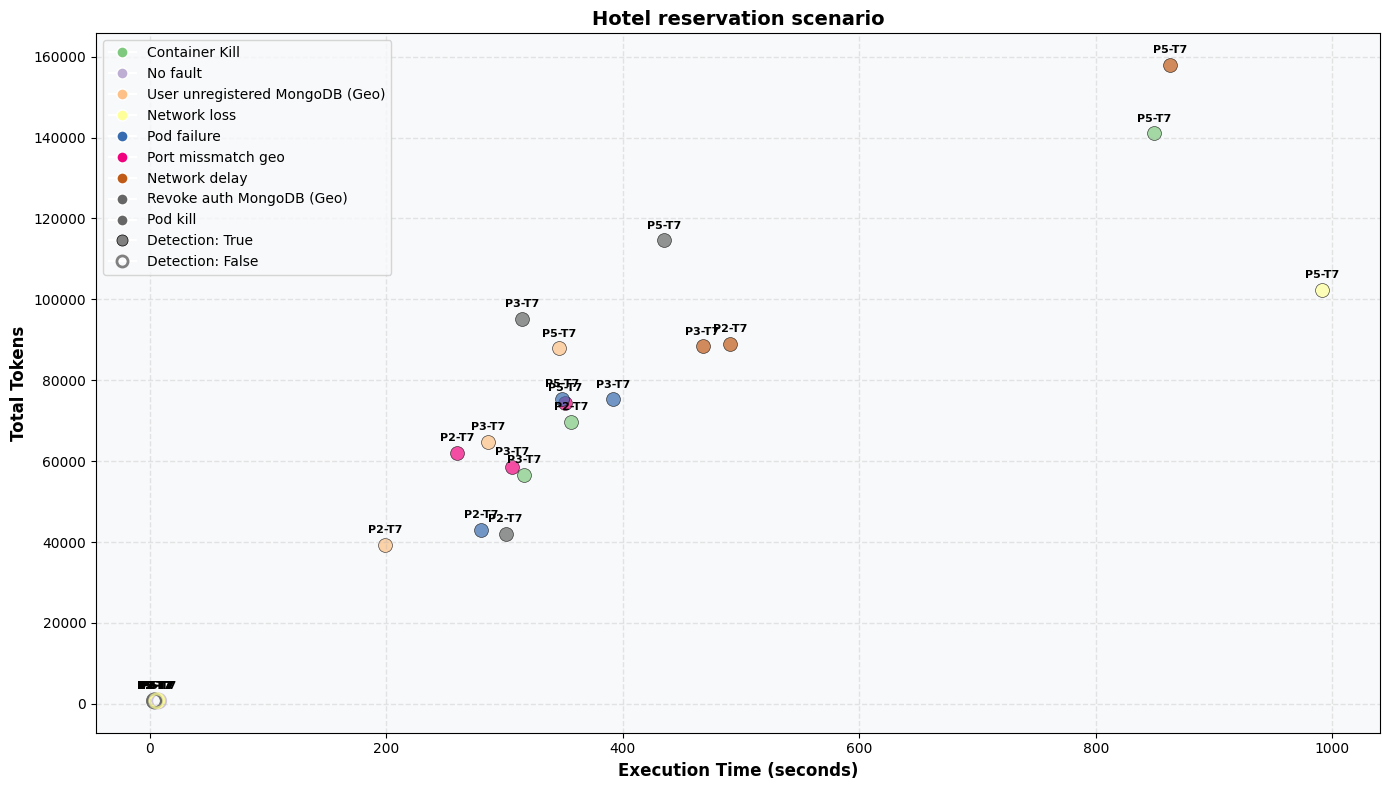

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Get unique fault types for coloring
fault_types = experiments_df['fault_name'].unique()
colors = plt.cm.Accent(np.linspace(0, 1, len(fault_types)))
color_map = {fault: colors[i] for i, fault in enumerate(fault_types)}

# Plot each experiment as a dot
for idx, row in experiments_df.iterrows():
    x = row['execution_time_seconds']
    y = row['total_tokens']
    fault = row['fault_name']
    color = color_map[fault]
    detection = row['detection']
    
    # Plot the dot - filled if detection is True, only border if False
    if detection:
        ax.scatter(x, y, s=100, color=color, alpha=0.7, edgecolors='black', linewidth=0.5)
    else:
        ax.scatter(x, y, s=100, facecolors='none', edgecolors=color, linewidth=2, alpha=0.7)
    
    # Add label with agent configuration on top of the dot
    label = f"P{int(row['rca_tasks_per_iteration'])}-T{int(row['max_tool_calls'])}"
    ax.annotate(label, (x, y), fontsize=8, ha='center', va='bottom', fontweight='bold', 
                xytext=(0, 7), textcoords='offset points')

# Create legend for fault types
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[fault], 
                       markersize=8, label=fault) for fault in fault_types]

# Add detection legend
detection_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=8, label='Detection: True', markeredgecolor='black', markeredgewidth=0.5),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
               markersize=8, label='Detection: False', markeredgecolor='gray', markeredgewidth=2)
]

# Combine all handles into a single legend
all_handles = handles + detection_handles
ax.legend(handles=all_handles, loc='upper left', fontsize=10)

# Labels and title
ax.set_xlabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Tokens', fontsize=12, fontweight='bold')
ax.set_title('Hotel reservation scenario', fontsize=14, fontweight='bold')

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


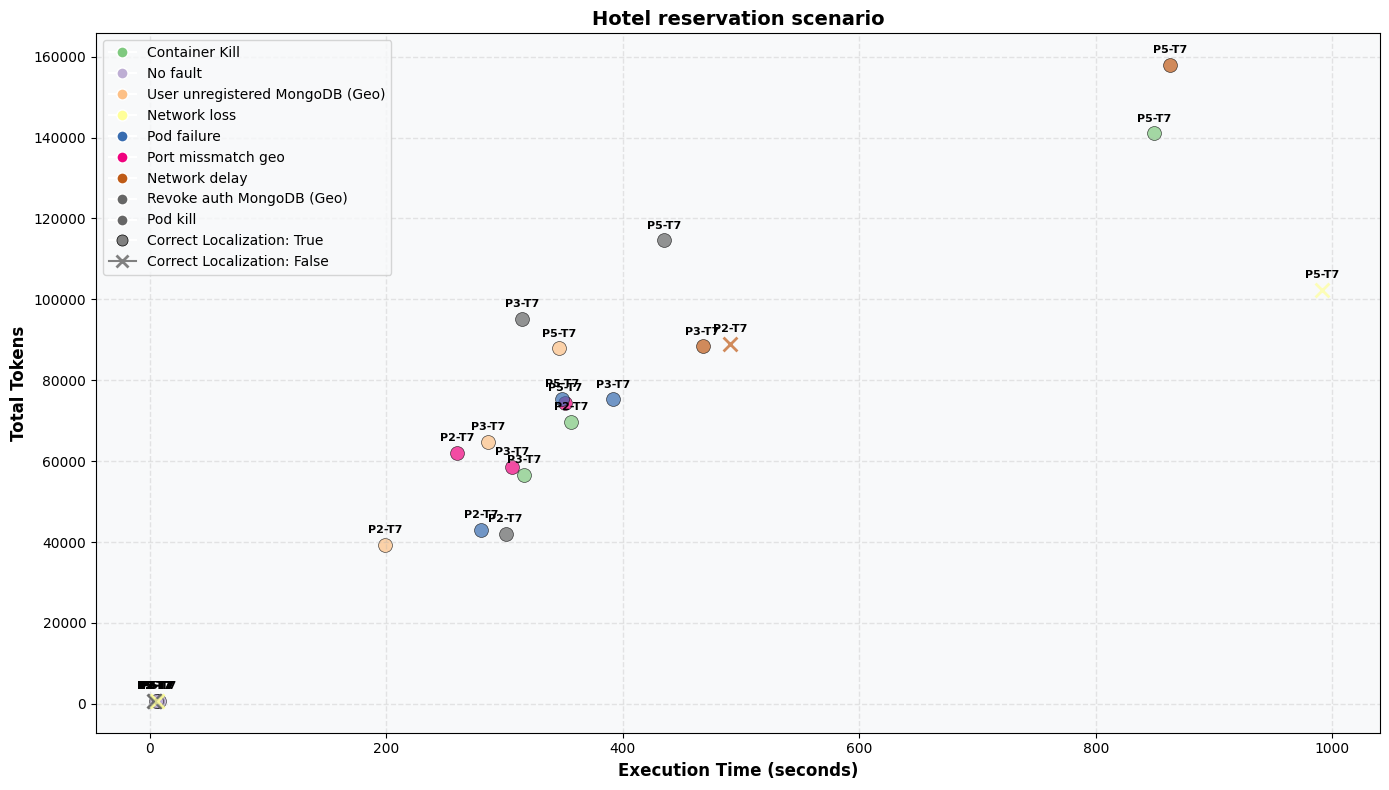

In [109]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Get unique fault types for coloring
fault_types = experiments_df['fault_name'].unique()
colors = plt.cm.Accent(np.linspace(0, 1, len(fault_types)))
color_map = {fault: colors[i] for i, fault in enumerate(fault_types)}

# Plot each experiment as a dot
for idx, row in experiments_df.iterrows():
    x = row['execution_time_seconds']
    y = row['total_tokens']
    fault = row['fault_name']
    color = color_map[fault]
    correct_localization = row['correct_localization']
    
    # Plot the dot - filled if correct_localization is True, X marker if False
    if correct_localization:
        ax.scatter(x, y, s=100, color=color, alpha=0.7, edgecolors='black', linewidth=0.5)
    else:
        ax.scatter(x, y, s=100, marker='x', color=color, linewidth=2, alpha=0.7)
    
    # Add label with agent configuration on top of the dot
    label = f"P{int(row['rca_tasks_per_iteration'])}-T{int(row['max_tool_calls'])}"
    ax.annotate(label, (x, y), fontsize=8, ha='center', va='bottom', fontweight='bold', 
                xytext=(0, 7), textcoords='offset points')

# Create legend for fault types
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[fault], 
                       markersize=8, label=fault) for fault in fault_types]

# Add localization legend
detection_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
               markersize=8, label='Correct Localization: True', markeredgecolor='black', markeredgewidth=0.5),
    plt.Line2D([0], [0], marker='x', color='gray', 
               markersize=8, label='Correct Localization: False', markeredgewidth=2)
]

# Combine all handles into a single legend
all_handles = handles + detection_handles
ax.legend(handles=all_handles, loc='upper left', fontsize=10)

# Labels and title
ax.set_xlabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Tokens', fontsize=12, fontweight='bold')
ax.set_title('Hotel reservation scenario', fontsize=14, fontweight='bold')

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


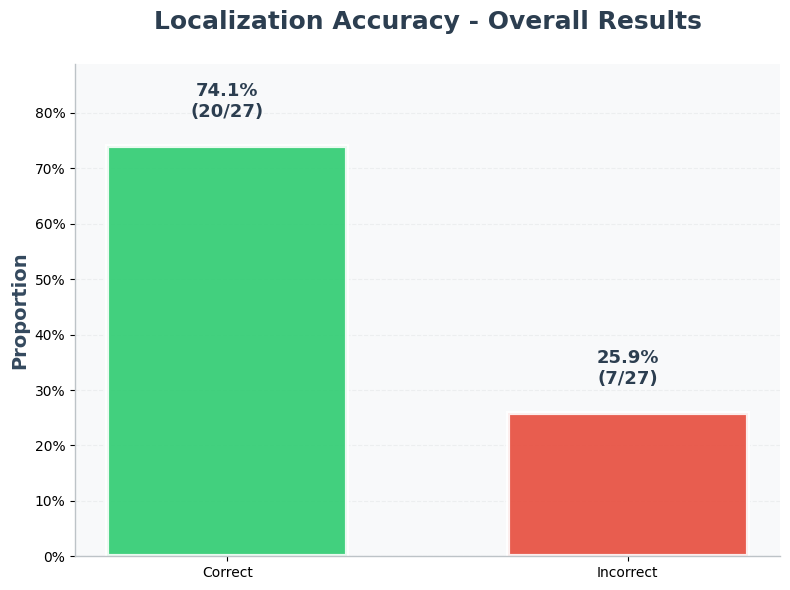

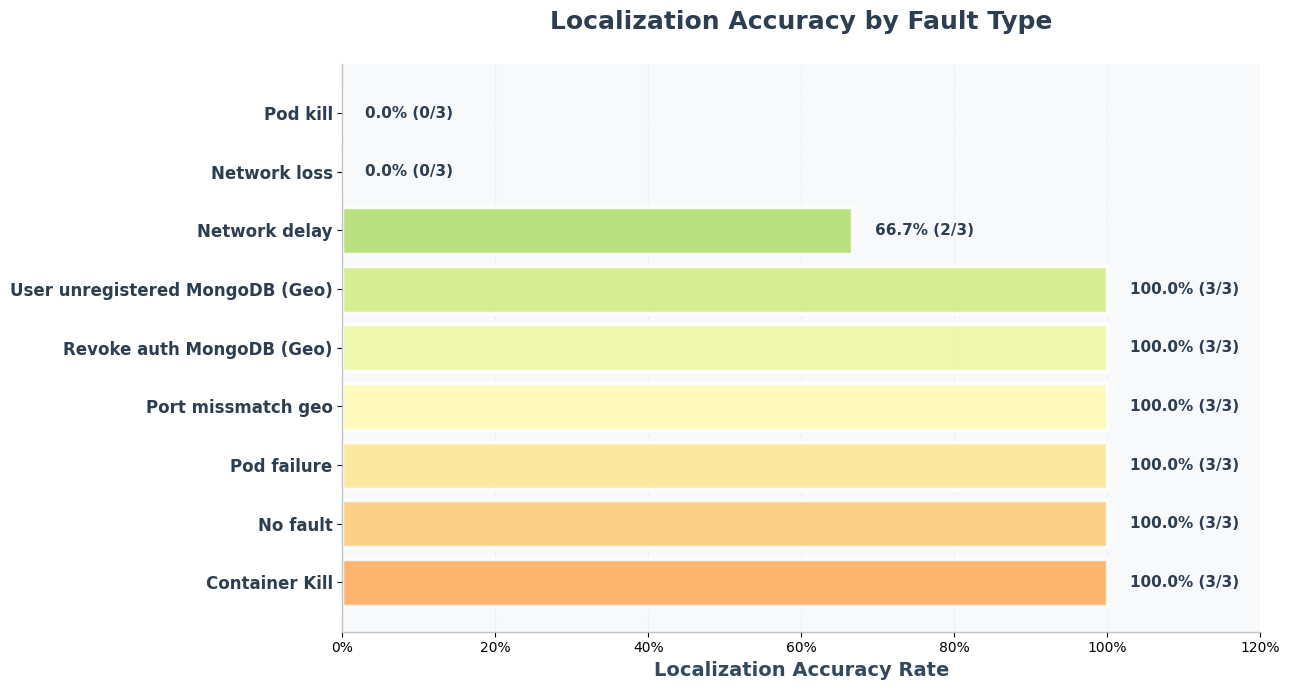

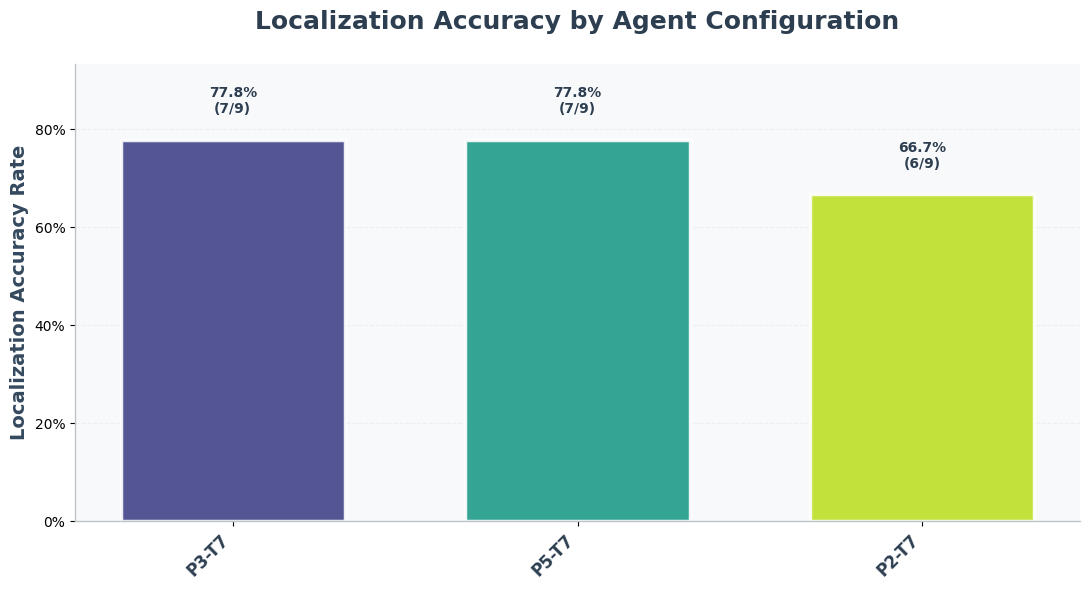

In [110]:
# Calculate distributions first
global_dist = experiments_df['correct_localization'].value_counts(normalize=True).sort_index(ascending=False)
fault_type_dist = experiments_df.groupby('fault_name')['correct_localization'].mean().sort_values(ascending=False)
agent_config_dist = experiments_df.groupby(['rca_tasks_per_iteration', 'max_tool_calls'])['correct_localization'].mean().sort_values(ascending=False)

import matplotlib.ticker as mtick
import seaborn as sns

# Set modern style
plt.style.use('default')
sns.set_palette("husl")

# Configure matplotlib for modern look
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['font.family'] = 'sans-serif'

# ============ GLOBAL DISTRIBUTION ============
fig, ax = plt.subplots(figsize=(8, 6))
colors_global = ['#2ecc71', '#e74c3c']
bars = ax.bar(['Correct', 'Incorrect'], [global_dist.get(True, 0), global_dist.get(False, 0)], 
              color=colors_global, edgecolor='white', linewidth=3, alpha=0.9, width=0.6)

ax.set_title('Localization Accuracy - Overall Results', fontsize=18, fontweight='bold', pad=25, color='#2c3e50')
ax.set_ylabel('Proportion', fontsize=14, fontweight='bold', color='#34495e')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0, max(global_dist.values) * 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc3c7')
ax.spines['bottom'].set_color('#bdc3c7')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.grid(axis='y', linestyle='--', alpha=0.2, linewidth=0.8, color='#bdc3c7')
ax.set_axisbelow(True)

# Add value labels
total = experiments_df.shape[0]
for i, (label, bar) in enumerate(zip(['Correct', 'Incorrect'], bars)):
    value = bar.get_height()
    count = int(value * total)
    ax.text(bar.get_x() + bar.get_width()/2, value + 0.045, f'{value*100:.1f}%\n({count}/{total})', 
            ha='center', va='bottom', fontsize=13, fontweight='bold', color='#2c3e50')

plt.tight_layout()
plt.show()

# ============ BY FAULT TYPE ============
fig, ax = plt.subplots(figsize=(13, 7))
colors_fault = plt.cm.RdYlGn(np.linspace(0.3, 0.8, len(fault_type_dist)))
bars = ax.barh(range(len(fault_type_dist)), fault_type_dist.values, 
               color=colors_fault, edgecolor='white', linewidth=2.5, alpha=0.9)

ax.set_yticks(range(len(fault_type_dist)))
ax.set_yticklabels(fault_type_dist.index, fontsize=12, fontweight='bold', color='#2c3e50')
ax.set_xlabel('Localization Accuracy Rate', fontsize=14, fontweight='bold', color='#34495e')
ax.set_title('Localization Accuracy by Fault Type', fontsize=18, fontweight='bold', pad=25, color='#2c3e50')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlim(0, 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc3c7')
ax.spines['bottom'].set_color('#bdc3c7')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.grid(axis='x', linestyle='--', alpha=0.2, linewidth=0.8, color='#bdc3c7')
ax.set_axisbelow(True)

# Add value labels
for i, (fault, rate) in enumerate(fault_type_dist.items()):
    total_fault = (experiments_df['fault_name'] == fault).sum()
    correct_fault = ((experiments_df['fault_name'] == fault) & (experiments_df['correct_localization'])).sum()
    ax.text(rate + 0.03, i, f'{rate*100:.1f}% ({correct_fault}/{total_fault})', 
            va='center', fontsize=11, fontweight='bold', color='#2c3e50')

plt.tight_layout()
plt.show()

# ============ BY AGENT CONFIGURATION ============
fig, ax = plt.subplots(figsize=(11, 6))
config_labels = [f"P{p}-T{t}" for p, t in agent_config_dist.index]
colors_config = plt.cm.viridis(np.linspace(0.2, 0.9, len(agent_config_dist)))
bars = ax.bar(range(len(agent_config_dist)), agent_config_dist.values,
              color=colors_config, edgecolor='white', linewidth=2.5, alpha=0.9, width=0.65)

ax.set_xticks(range(len(agent_config_dist)))
ax.set_xticklabels(config_labels, fontsize=12, fontweight='bold', color='#2c3e50', rotation=45, ha='right')
ax.set_ylabel('Localization Accuracy Rate', fontsize=14, fontweight='bold', color='#34495e')
ax.set_title('Localization Accuracy by Agent Configuration', fontsize=18, fontweight='bold', pad=25, color='#2c3e50')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0, max(agent_config_dist.values) * 1.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#bdc3c7')
ax.spines['bottom'].set_color('#bdc3c7')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.grid(axis='y', linestyle='--', alpha=0.2, linewidth=0.8, color='#bdc3c7')
ax.set_axisbelow(True)

# Add value labels
for i, ((p, t), rate) in enumerate(agent_config_dist.items()):
    mask = (experiments_df['rca_tasks_per_iteration'] == str(p)) & (experiments_df['max_tool_calls'] == str(t))
    total_cfg = mask.sum()
    correct_cfg = (mask & experiments_df['correct_localization']).sum()
    ax.text(i, rate + 0.048, f'{rate*100:.1f}%\n({correct_cfg}/{total_cfg})', 
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='#2c3e50')

plt.tight_layout()
plt.show()


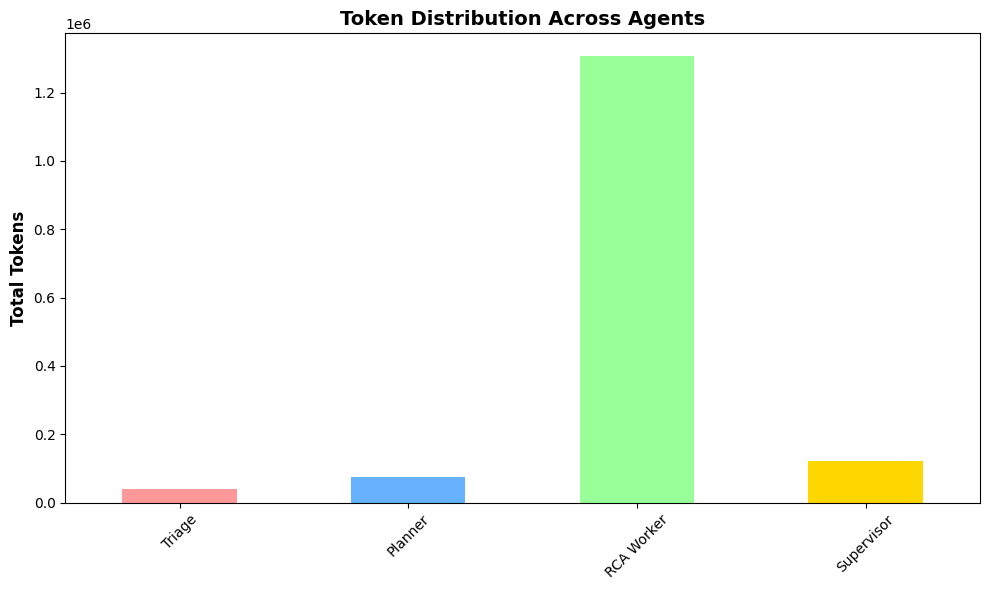

In [84]:
agent_tokens = experiments_df[[
    'tokens_triage',
    'tokens_planner', 
    'tokens_rca_worker',
    'tokens_supervisor'
]].sum()

fig, ax = plt.subplots(figsize=(10, 6))
agent_tokens.plot(kind='bar', ax=ax, color=['#FF9999', '#66B2FF', '#99FF99', '#FFD700'])
ax.set_ylabel('Total Tokens', fontsize=12, fontweight='bold')
ax.set_title('Token Distribution Across Agents', fontsize=14, fontweight='bold')
ax.set_xticklabels(['Triage', 'Planner', 'RCA Worker', 'Supervisor'], rotation=45)
plt.tight_layout()
plt.show()

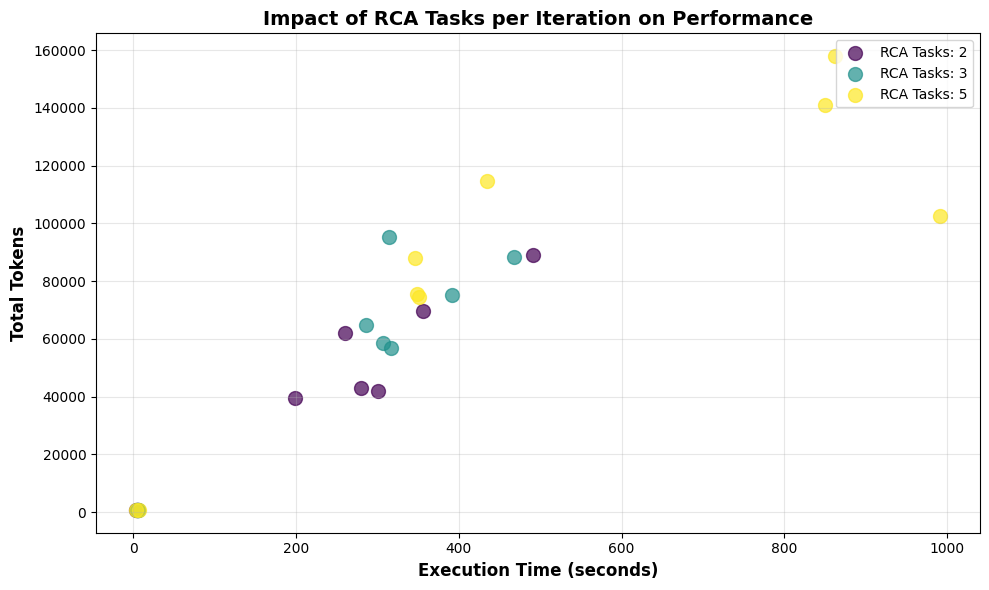

In [85]:
fig, ax = plt.subplots(figsize=(10, 6))
iterations = experiments_df['rca_tasks_per_iteration'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(iterations)))

for i, iter_val in enumerate(sorted(iterations)):
    mask = experiments_df['rca_tasks_per_iteration'] == iter_val
    ax.scatter(experiments_df[mask]['execution_time_seconds'], 
              experiments_df[mask]['total_tokens'],
              label=f'RCA Tasks: {int(iter_val)}',
              s=100, alpha=0.7, color=colors[i])

ax.set_xlabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Tokens', fontsize=12, fontweight='bold')
ax.set_title('Impact of RCA Tasks per Iteration on Performance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()